# Optimizations with Physical Gradients

Test equations: properly define z in R2 to R2 etc. <br>
 <br>
 
$\mathbf{z}(\mathbf{x}) = \mathbf{z}(x_0,x_1) = [x_0 \ x_1^2]^T$ <br>
$L(\mathbf{z}) = |\mathbf{z}|^2 = z_0^2 + z_1^2$ <br>

(Note, to be in sync with python arrays, indices start at 0 here.)

...

In [1]:
import jax
import jax.numpy as np
import numpy as onp


# "physics" function z
def fun_z(x):
    return np.array( [x[0], x[1]*x[1]] )

# simple L2 loss
def fun_L(z):
    #return z[0]*z[0] + z[1]*z[1] # "manual version"
    return np.sum( np.square(z) )

# composite function with L & z
def fun(x):
    return fun_L(fun_z(x))


x = np.asarray([3,3], dtype=np.float32)

print("Some test calls:") 
fun_z(x) , fun_L( fun_z(x) ), fun(x), fun([0,0])

Some test calls:


(DeviceArray([3., 9.], dtype=float32),
 DeviceArray(90., dtype=float32),
 DeviceArray(90., dtype=float32),
 DeviceArray(0, dtype=int32))

In [2]:

# this works:
print("Jacobian L(z): " + format(jax.grad(fun_L)(fun_z(x))) )

# the following would give an error as z (and hence fun_z) is not scalar
#jax.grad(fun_z)(x) 

# computing the jacobian of z is a valid operation:
J = jax.jacobian(fun_z)(x)
print( "Jacobian z(x): \n" + format(J) ) 

# the following also gives error, JAX grad needs a single function object
#jax.grad( fun_L(fun_z) )(x) 

# instead use composite 'fun' from above
print("Gradient for full L(x): " + format( jax.grad(fun)(x) ) )

print( "\nSanity check with inverse Jacobian of z, this should give x again: " + format(np.linalg.solve(J, np.matmul(J,x) )) )


Jacobian L(z): [ 6. 18.]
Jacobian z(x): 
[[1. 0.]
 [0. 6.]]
Gradient for full L(x): [  6. 108.]

Sanity check with inverse Jacobian of z, this should give x again: [3. 3.]


This already shows a problem, the gradient mostly points along $x_2$ with 108! 
We know both dimensions should go towards zero, this points to problems...

## Gradient descent

Update step:<br>

$\Delta \mathbf{x} = 
- \eta ( J_{L} J_{\mathbf{z}} )^T
=
- \eta ( \frac{\partial L }{ \partial \mathbf{z} } \frac{\partial \mathbf{z} }{ \partial \mathbf{x} }  )^T$

with step size $\eta$, 
start at $x=[3,3]$

...

In [3]:
x = np.asarray([3.,3.])
eta = 0.01
history = [x]; updates = []

for i in range(10):
    G = jax.grad(fun)(x)
    x += -eta * G
    history.append(x); updates.append(G)
    print( "GD iter %d: "%i + format(x) )


GD iter 0: [2.94      1.9200001]
GD iter 1: [2.8812    1.6368846]
GD iter 2: [2.823576  1.4614503]
GD iter 3: [2.7671044 1.3365935]
GD iter 4: [2.7117622 1.2410815]
GD iter 5: [2.657527  1.1646168]
GD iter 6: [2.6043763 1.1014326]
GD iter 7: [2.5522888 1.0479842]
GD iter 8: [2.501243  1.0019454]
GD iter 9: [2.4512184  0.96171147]


Let's look at the progression of this...
Target shown in black

Text(0, 0.5, 'x1')

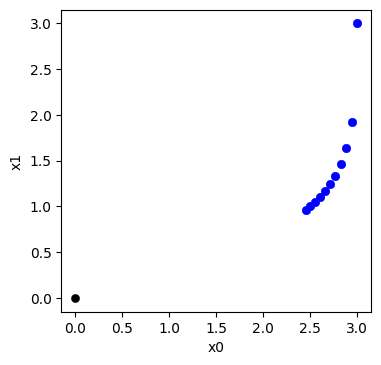

In [4]:
import matplotlib.pyplot as plt
axes = plt.figure(figsize=(4, 4), dpi=100).gca()
historyGD = onp.asarray(history)
updatesGD = onp.asarray(updates) # for later
axes.scatter(historyGD[:,0], historyGD[:,1], lw=0.5, color='blue')
axes.scatter([0], [0], lw=0.25, color='black') # target at 0,0
axes.set_xlabel('x0')
axes.set_ylabel('x1')

## Newton

For Newton's method, let's consider the combined function, i.e., 
$L(\mathbf{x}) = x_0^2 + x_1^4$
...

Newton's method update step is given by
$
\Delta \mathbf{x} = 
- \eta \left( \frac{\partial^2 L }{ \partial \mathbf{x}^2 }  \right)^{-1}
  \frac{\partial L }{ \partial \mathbf{x} }
=
- \eta \ H_L^{-1} \ ( J_{L} J_{\mathbf{z}} )^T
$

Hence we need to compute the Hessian and its inverse, easy in JAX, and very cheap here, but not so simple in practice...


In [5]:
x = np.asarray([3.,3.])
eta = 1./3.
history = [x]; updates = []

for i in range(10):
    G = jax.grad(fun)(x)
    H = jax.jacobian(jax.jacobian(fun))(x)
    #H = jax.jacfwd(jax.jacrev(fun_Lz))(x) # more efficient?    
    Hinv = np.linalg.inv(H)
    
    x += -eta * np.matmul( Hinv , G)
    history.append(x); updates.append( np.matmul( Hinv , G) )
    print( "Newton iter %d: "%i + format(x) )



Newton iter 0: [2.        2.6666667]
Newton iter 1: [1.3333333 2.3703704]
Newton iter 2: [0.88888884 2.1069958 ]
Newton iter 3: [0.59259254 1.8728852 ]
Newton iter 4: [0.39506167 1.6647868 ]
Newton iter 5: [0.26337445 1.4798105 ]
Newton iter 6: [0.17558296 1.315387  ]
Newton iter 7: [0.1170553 1.1692328]
Newton iter 8: [0.07803687 1.0393181 ]
Newton iter 9: [0.05202458 0.92383826]


Let's compare, Newton actually does better, note - uses different step size...

Text(0, 0.5, 'x1')

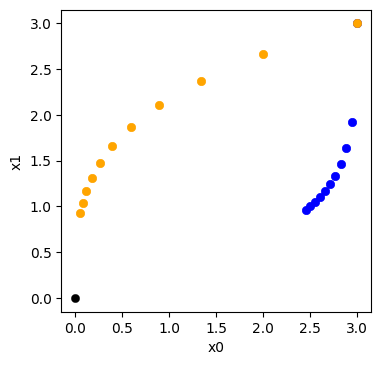

In [6]:
axes = plt.figure(figsize=(4, 4), dpi=100).gca()
historyNt = onp.asarray(history)
updatesNt = onp.asarray(updates) 
axes.scatter(historyGD[:,0], historyGD[:,1], lw=0.5, color='blue')
axes.scatter(historyNt[:,0], historyNt[:,1], lw=0.5, color='orange')
axes.scatter([0], [0], lw=0.25, color='black') # target at 0,0
axes.set_xlabel('x0')
axes.set_ylabel('x1')

## Physical Gradients

Now we also use the _inverse physics_, i.e. the inverse of z:
$\mathbf{z}^{-1}(\mathbf{x}) = [x_0 \ x_1^{1/2}]^T$

Let’s call intermediate physical result $\mathbf{y}$, i.e. 
$\mathbf{z}(\mathbf{x}) = \mathbf{y}$

With an update step:
$
\Delta \mathbf{x} = 
\mathbf{z}^{-1} \left( \mathbf{y} - \eta_L 
  \left( \frac{\partial^2 L }{ \partial \mathbf{z}^2 }  \right)^{-1}
  \frac{\partial L }{ \partial \mathbf{z} }
\right) - \mathbf{x}
$




In [7]:
x = np.asarray([3.,3.])
eta = 0.3
history = [x]; updates = []

def fun_z_inv_analytic(y):
    return np.array( [y[0], np.power(y[1],0.5)] )

for i in range(10):
    y = fun_z(x)
    
    # Newton step for L(y)
    GL = jax.grad(fun_L)(y)
    HL = jax.jacobian(jax.jacobian(fun_L))(y)
    HLinv = np.linalg.inv(HL)
    y += -eta * np.matmul( HLinv , GL)

    # "inverse physics" step via z-inverse
    x = fun_z_inv_analytic(y)
    history.append(x)
    updates.append( history[-2] - history[-1] )
    print( "PG iter %d: "%i + format(x) )



PG iter 0: [2.1       2.5099802]
PG iter 1: [1.4699999 2.1000001]
PG iter 2: [1.0289999 1.7569861]
PG iter 3: [0.72029996 1.47      ]
PG iter 4: [0.50421   1.2298902]
PG iter 5: [0.352947 1.029   ]
PG iter 6: [0.24706289 0.86092323]
PG iter 7: [0.17294402 0.7203    ]
PG iter 8: [0.12106082 0.60264623]
PG iter 9: [0.08474258 0.50421   ]


All together now

Text(0, 0.5, 'x1')

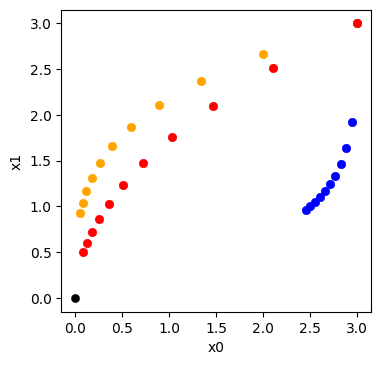

In [8]:
axes = plt.figure(figsize=(4, 4), dpi=100).gca()
historyPG = onp.asarray(history)
updatesPG = onp.asarray(updates) 
axes.scatter(historyGD[:,0], historyGD[:,1], lw=0.5, color='blue')
axes.scatter(historyNt[:,0], historyNt[:,1], lw=0.5, color='orange')
axes.scatter(historyPG[:,0], historyPG[:,1], lw=0.5, color='red')
axes.scatter([0], [0], lw=0.25, color='black') # target at 0,0
axes.set_xlabel('x0')
axes.set_ylabel('x1')

So, PG does best...
Also most _diagonal_, i.e., direct path to target

Difference also shows in first update steps: compare...
GD mostly "down" along x1, Newton mostly along x0, PG is nicely diagonal.

In [9]:
def mag(x):
    return np.sqrt(np.sum(np.square(x)))

def one_len(x):
    return np.dot( x/mag(x), np.array([1,1])) 

print("Diagonal lengths (larger is better): GD %f, Nt %f, PG %f " % 
      (one_len(updatesGD[0]) , one_len(updatesNt[0]) , one_len(updatesPG[0])) )


Diagonal lengths (larger is better): GD 1.053930, Nt 1.264911, PG 1.356443 


## Approximate Inversions

We can use BFGS if inverse of z is not readily available

Just a bit ugly for calling `fmin_l_bfgs_b()` from scipy:

In [10]:
#import numpy as np
import jax.numpy as np

def fun_z_inv_opt(target_y, x_ini):
    # a bit ugly, we switch to pure scipy here inside each iteration for BFGS
    import numpy as np
    from scipy.optimize import fmin_l_bfgs_b
    target_y = onp.array(target_y)
    x_ini    = onp.array(x_ini)

    def fun_z_opt(x,target_y=[2,2]):
        y = onp.array( [x[0], x[1]*x[1]] ) # we cant use fun_z from JAX here
        ret = onp.sum( onp.square(y-target_y) )
        return ret
    
    ret = fmin_l_bfgs_b(lambda x: fun_z_opt(x,target_y), x_ini, approx_grad=True )
    #print( ret ) # full BFGS details
    return ret[0]

print("BFGS optimization test run, find x such that y=[2,2]:")
fun_z_inv_opt([2,2], [3,3])


BFGS optimization test run, find x such that y=[2,2]:


array([2.00000003, 1.41421353])

In [11]:
x = np.asarray([3.,3.])
eta = 0.3
history = [x]; updates = []

for i in range(10):    
    # same as before, Newton step for L(y)
    y = fun_z(x)
    GL = jax.grad(fun_L)(y)
    y += -eta * np.matmul( np.linalg.inv( jax.jacobian(jax.jacobian(fun_L))(y) ) , GL)

    # optimize for inverse physics, assuming we dont have access to an inverse for fun_z
    x = fun_z_inv_opt(y,x)
    history.append(x)
    updates.append( history[-2] - history[-1] )
    print( "PG iter %d: "%i + format(x) )


PG iter 0: [2.09999967 2.50998022]
PG iter 1: [1.46999859 2.10000011]
PG iter 2: [1.02899871 1.75698602]
PG iter 3: [0.72029824 1.4699998 ]
PG iter 4: [0.50420733 1.22988982]
PG iter 5: [0.35294448 1.02899957]
PG iter 6: [0.24705997 0.86092355]
PG iter 7: [0.17294205 0.72030026]
PG iter 8: [0.12106103 0.60264817]
PG iter 9: [0.08474171 0.50421247]


Nice! It works, just like PG. Not much point plotting this, it's basiclly the PG version, but let's measure the difference...

In [12]:
historyPGa = onp.asarray(history)
updatesPGa = onp.asarray(updates) 

print("Diff analytic PG versus approximated: %f" % (np.sum(np.abs(historyPGa-historyPG))) )


Diff analytic PG versus approximated: 0.000022


## Conclusions 
That concludes simple example...

Main takeaways:
* PGs work neatly
* much faster convergence
    
Coming up, complex example.

## Next Steps

Try
- X
- Y